In [21]:
# ===== Core Python / Utilities =====
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2

# ===== Scikit-learn (evaluation, preprocessing, split) =====
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

In [22]:
def load_images_for_cnn(folder_label_pairs, image_size=(224, 224), pad_color=(255,255,255)):
    """
    Loads and pads all images for CNN training.
    Keeps 3D shape (H, W, 3) instead of flattening.
    """
    X, y = [], []

    for folder, label in folder_label_pairs:
        image_files = [f for f in os.listdir(folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for filename in tqdm(image_files, desc=f"Loading {os.path.basename(folder)}"):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert("RGB")

                # Resize while preserving aspect ratio + pad
                img.thumbnail(image_size, Image.Resampling.LANCZOS)
                background = Image.new("RGB", image_size, pad_color)
                offset = ((image_size[0]-img.width)//2, (image_size[1]-img.height)//2)
                background.paste(img, offset)

                img_array = np.array(background) / 255.0
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"⚠️ Skipped {filename}: {e}")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    return X, y

In [23]:
class1_folder = r"E:\POC_Jain_Irrigation\data\A\train_cropped"
class2_folder = r"E:\POC_Jain_Irrigation\data\BC\train_cropped"
class3_folder = r"E:\POC_Jain_Irrigation\data\D\train_cropped"

folders = [
    (class1_folder, 1),
    (class2_folder, 2),
    (class3_folder, 3)
]

X, y = load_images_for_cnn(folders, image_size=(224,224))
print(X.shape, y.shape)

Loading train_cropped: 100%|███████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 99.85it/s]


(256, 224, 224, 3) (256,)


In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

y_train_cat = to_categorical(y_train - 1)  # if labels start at 1
y_test_cat  = to_categorical(y_test - 1)

CNN's

In [25]:
def build_cnn_a(input_shape=(224,224,3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
def build_cnn_b(input_shape=(224,224,3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [27]:
def build_cnn_c(input_shape=(224,224,3), num_classes=3):
    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False  # freeze base layers

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [28]:
# assuming X_train, X_test, y_train, y_test already prepared
y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)

EPOCHS = 20
BATCH_SIZE = 32

models = {
    "CNN_A": build_cnn_a(),
    "CNN_B": build_cnn_b(),
    "CNN_C": build_cnn_c()
}

histories = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    hist = model.fit(
        X_train, y_train_cat,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    histories[name] = hist


E:\Jain Irrigation\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN_A...
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.3706 - loss: 2.8948 - val_accuracy: 0.3333 - val_loss: 1.2924
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3287 - loss: 1.1302 - val_accuracy: 0.1667 - val_loss: 1.2007
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.3916 - loss: 1.0926 - val_accuracy: 0.5000 - val_loss: 1.0319
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.4965 - loss: 1.0379 - val_accuracy: 0.6111 - val_loss: 0.9904
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7133 - loss: 0.8543 - val_accuracy: 0.8611 - val_loss: 0.6629
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7343 - loss: 0.6022 - val_accuracy: 0.7778 - val_loss: 0.5004
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8322 - loss: 0.4464 - val_accuracy: 0.7222 - val_loss: 0.5108
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8741 - loss: 0.3116 - val_accuracy:


🔹 Evaluating CNN_A...
Test Accuracy: 0.896
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.86      0.79      0.83        24
           2       1.00      0.89      0.94        28

    accuracy                           0.90        77
   macro avg       0.90      0.89      0.89        77
weighted avg       0.90      0.90      0.90        77



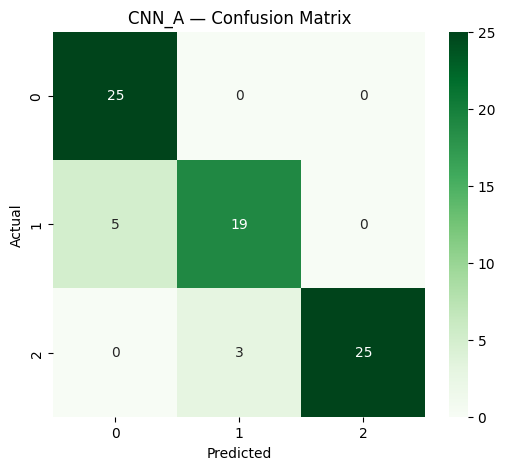


🔹 Evaluating CNN_B...
Test Accuracy: 0.364
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        24
           2       0.36      1.00      0.53        28

    accuracy                           0.36        77
   macro avg       0.12      0.33      0.18        77
weighted avg       0.13      0.36      0.19        77



E:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\Jain Irrigation\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


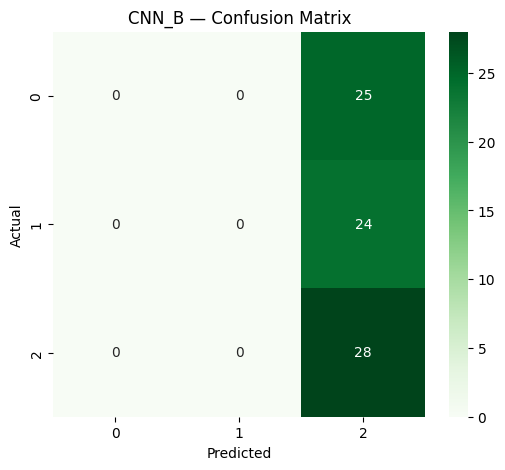


🔹 Evaluating CNN_C...
Test Accuracy: 0.948
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.88      0.96      0.92        24
           2       1.00      0.93      0.96        28

    accuracy                           0.95        77
   macro avg       0.95      0.95      0.95        77
weighted avg       0.95      0.95      0.95        77



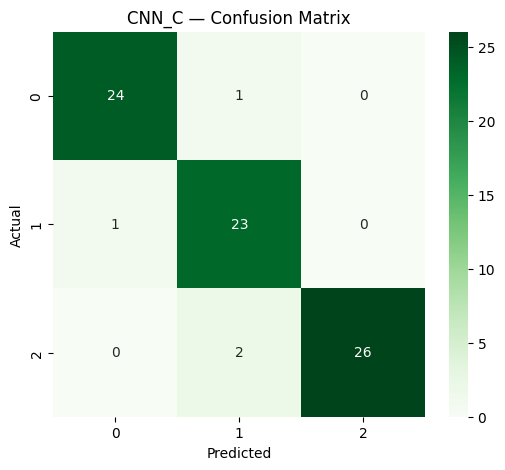

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = {}

for name, model in models.items():
    print(f"\n🔹 Evaluating {name}...")
    # Evaluate on test data
    loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Test Accuracy: {acc:.3f}")

    # Predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test - 1  # because of one-hot encoding offset

    # Detailed report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Store results
    results[name] = {"accuracy": acc, "loss": loss, "cm": cm}

In [20]:
os.makedirs("saved_models", exist_ok=True)
models["CNN_A"].save("saved_models/cnn_a.keras")
models["CNN_B"].save("saved_models/cnn_b.keras")
models["CNN_C"].save("saved_models/cnn_c.keras")